In [1]:
from google.colab import drive
from os.path import join
ROOT = "/content/drive"
print(ROOT)
drive.mount(ROOT, force_remount=True)

/content/drive
Mounted at /content/drive


In [2]:
%tensorflow_version 2.0.0

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.0.0`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [3]:
# Load useful libraries
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.metrics import *

# Plotting libraries
import matplotlib.pyplot as plt
plt.gray()

<Figure size 432x288 with 0 Axes>

In [4]:
tf.config.experimental.list_physical_devices('GPU')

[]

In [0]:
directory = "/content/drive/My Drive/data/"

In [0]:
x_headers = [
    "eye_ratio", "head_size", "ear_ratio", 
    "conf_head", "conf_eye_0", "conf_eye_1", 
    "conf_ear_0", "conf_ear_1", "conf_nose", "sharpness"
]

In [7]:
predictors = np.loadtxt(f"{directory}x_results.txt")
predictors_df = pd.DataFrame(predictors, columns=x_headers)
display(predictors_df)

frames_df = pd.read_csv(f"{directory}labeled_results_418.csv", names=["labeler", "video", "frame_seconds", "score"])
# Grab ONLY the frames where there's a cat
frames_df = frames_df[frames_df["score"] > 0].reset_index()
display(frames_df)

,eye_ratio,head_size,ear_ratio,conf_head,conf_eye_0,conf_eye_1,conf_ear_0,conf_ear_1,conf_nose,sharpness
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.285022,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.894592,0.000000,0.806655,0.000000,0.578450,0.000000
...,...,...,...,...,...,...,...,...,...,...
142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
143,0.872194,0.050633,0.000000,0.835639,0.913628,0.745760,0.700000,0.000000,0.659196,1801.518863
144,0.576636,0.053261,0.942257,0.346079,0.876601,0.869548,0.859990,0.651589,0.346202,191.416360
145,0.890909,0.045992,0.904147,0.644881,0.963726,0.678370,0.706430,0.690395,0.919236,329.533163


,index,labeler,video,frame_seconds,score
0,0,all,cat15.mp4,2.133385,2
1,1,all,cat74.mp4,13.984110,3
2,2,all,cat75.mp4,14.685697,2
3,3,all,cat21.mp4,2.282946,2
4,4,all,cat65.mp4,1.214871,4
...,...,...,...,...,...
142,156,all,cat35.mp4,3.484597,1
143,157,all,cat63.mp4,7.950350,4
144,158,all,cat30.mp4,3.723101,3
145,160,all,cat29.mp4,15.945570,5


In [8]:
from PIL import Image

"""
First, let's sort the videos by frame, so that we don't have to load a new video instance unnecessarily.

Then, we'll loop through each item here and recover all of the labelled frames, grab the images, and store them as files.
"""
frames_cnn = frames_df.copy()

# Add a column to store the image data
frames_cnn["images"] = None

for i, frame in frames_cnn.iterrows():
  video_name = frame["video"].split(".mp4")[0]
  frames_cnn["images"][i] = np.array(Image.open(f"{directory}frames/{i}_{video_name}.png"))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


(1920, 1080, 3)

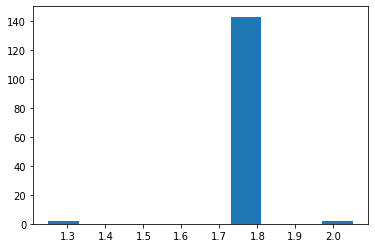

In [9]:
frames_cnn.head()

"""
Get all images loaded into the dataframes as one huge numpy array to work with for now. 
"""
numpy_images = frames_cnn["images"].to_numpy()

"""
Do some very brief EDA to see the max and min dimensions on the images, 
to get a sense of how I should crop or resize.
"""
aspect_ratios = []

for image_array in numpy_images:
    if image_array.shape[0] >  image_array.shape[1]:
        aspect_ratios.append(image_array.shape[0] / image_array.shape[1])
    else:
        aspect_ratios.append(image_array.shape[1] / image_array.shape[0])

plt.hist(aspect_ratios)

frames_cnn["aspect_ratios"] = np.array(aspect_ratios)
frames_cnn.head()

numpy_images[0].shape

In [0]:
"""
Based on some of the investigations above, most of the images have the same aspect ratio, 
save for a few. Given this, I'm not too worried about cropping; we should stick
to the most frequent aspect ratio and crop everything accordingly. I think it will be
OK if a couple of the images have padding.

But to get the images as uniform as possible, let's lay all the images horizontally.
I don't think the orienting the images for training purposes will affect the outcome.
"""
images_horizontal = []
for image_array in numpy_images:
    """
    If image is vertical, rotate it 90 degrees.
    Since images are always: height, width, depth
    """
    if image_array.shape[0] >  image_array.shape[1]:
        image_array = np.rot90(image_array)
    images_horizontal.append(image_array)

images_horizontal = np.array(images_horizontal)

1.7733990147783252

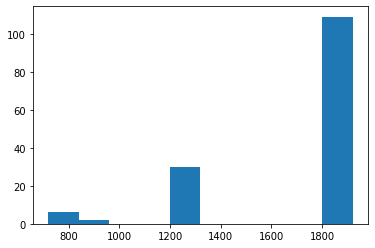

In [11]:
widths = [x.shape[1] for x in images_horizontal]
plt.hist(widths)
minimum_width_image = images_horizontal[np.argmin(widths)]
"""
The minimum width image is still an aspect ratio of ~16:9
"""
minimum_width_image.shape[1] / minimum_width_image.shape[0]

In [12]:
"""
Examine the smallest photo
"""
print(minimum_width_image.shape[1])
print(minimum_width_image.shape[0])

720
406


In [13]:
recrop_size = (158, 280)

def tf_norm_crop_resize_image(image, resize_dim):
    """Normalizes image to [0.,1.], crops to dims (720, 406, 3)
    and resizes to `resize_dim`, returning an image tensor."""
    image = tf.cast(image, tf.float32) / 255.
    image = tf.image.resize_with_crop_or_pad(image, 1080, 1920)
    image = tf.image.resize(image, resize_dim)
    image.set_shape(resize_dim + (3,))
    return image

cropped_images = np.empty((len(images_horizontal), recrop_size[0], recrop_size[1], 3))
for i, image in enumerate(images_horizontal):
    cropped_image = tf_norm_crop_resize_image(image, recrop_size)
    cropped_images[i] = cropped_image
    print(f"Cropped and reshaped image: {i}")

Cropped and reshaped image: 0
Cropped and reshaped image: 1
Cropped and reshaped image: 2
Cropped and reshaped image: 3
Cropped and reshaped image: 4
Cropped and reshaped image: 5
Cropped and reshaped image: 6
Cropped and reshaped image: 7
Cropped and reshaped image: 8
Cropped and reshaped image: 9
Cropped and reshaped image: 10
Cropped and reshaped image: 11
Cropped and reshaped image: 12
Cropped and reshaped image: 13
Cropped and reshaped image: 14
Cropped and reshaped image: 15
Cropped and reshaped image: 16
Cropped and reshaped image: 17
Cropped and reshaped image: 18
Cropped and reshaped image: 19
Cropped and reshaped image: 20
Cropped and reshaped image: 21
Cropped and reshaped image: 22
Cropped and reshaped image: 23
Cropped and reshaped image: 24
Cropped and reshaped image: 25
Cropped and reshaped image: 26
Cropped and reshaped image: 27
Cropped and reshaped image: 28
Cropped and reshaped image: 29
Cropped and reshaped image: 30
Cropped and reshaped image: 31
Cropped and reshap

In [0]:
train_indices = range(122)
test_indices = range(122, 147)

X_train = cropped_images[train_indices]
y_train = frames_df.iloc[train_indices]["score"]

X_test = cropped_images[test_indices]
y_test = frames_df.iloc[test_indices]["score"]

"""
Subtract 1 because the Dense layer will output a score from 0 - 4.

This means that any result we have, we'll need to add a 1 to it later to compare
back to the original.
"""
y_train = y_train - 1
y_test = y_test - 1

In [30]:
sample_image = X_train[0]
cnn_model = models.Sequential()

optimizer = "adam"
metrics=["accuracy"]

# 1st convolutional layer
cnn_model.add(layers.Conv2D(
    filters=256, 
    kernel_size=(3, 3),
    activation='relu',
    padding="same", 
    input_shape=sample_image.shape
  )
)

# 2nd convolutional layer + max pooling
cnn_model.add(layers.Conv2D(
    filters=64, 
    kernel_size=(3, 3),
    activation='relu',
    padding="same", 
  )
)
cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(layers.Dropout(0.30))


# Output:
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(5, activation='softmax'))

# Compile model
cnn_model.compile(
    optimizer=optimizer,
    # Since we did not one-hot encode this, we'll use sparse categorical crossentropy
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=metrics
)

cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 158, 280, 256)     7168      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 158, 280, 64)      147520    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 79, 140, 64)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 79, 140, 64)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 707840)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 3539205   
Total params: 3,693,893
Trainable params: 3,693,893
Non-trainable params: 0
____________________________________________

In [32]:
history = cnn_model.fit(
    X_train,
    y_train,
    epochs=3,
    verbose=1, 
    validation_split=0.1,
)

Epoch 1/3
4/4 [==============================] - 83s 21s/step - loss: 5.2735 - accuracy: 0.3211 - val_loss: 1.5801 - val_accuracy: 0.3846
Epoch 2/3
4/4 [==============================] - 85s 21s/step - loss: 1.5466 - accuracy: 0.3853 - val_loss: 1.3526 - val_accuracy: 0.3846
Epoch 3/3
4/4 [==============================] - 83s 21s/step - loss: 1.4044 - accuracy: 0.4495 - val_loss: 1.1402 - val_accuracy: 0.4615


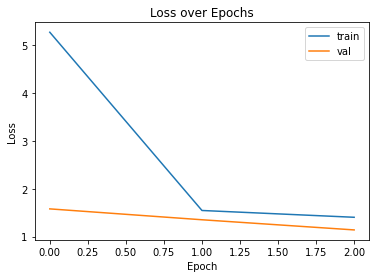

In [33]:
"""
Citation: This is code that I took from one of my old data science assignments
"""

def print_history(history):
    plt.plot((history.history["loss"]), label="train")
    plt.plot((history.history["val_loss"]), label="val")
    plt.xlabel(r"Epoch")
    plt.ylabel(r"Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    plt.show()

print_history(history)

In [0]:
"""
I'm pretty tired, so I'm going to stop right here. Obviously, this needs 
to be trained some more because it's hasn't converged enough, and train accuracy
is only at 0.45%. It's possible that more epochs will do the trick, but I'm also
suspicious, and I suspect that we will need much, much more data.

But regardless, here is a prediction of the images:
"""

predictions = cnn_model.predict(X_test)

In [47]:
predicted_scores = np.array([np.argmax(x) for x in predictions])

print("ACTUAL (top) VS PREDICTED SCORES (bottom)")
print(y_test.values)
print(predicted_scores)

from sklearn.metrics import accuracy_score

total_score = accuracy_score(y_test, predicted_scores)
print(f"Total Score: {total_score}")

ACTUAL (top) VS PREDICTED SCORES (bottom)
[0 3 2 4 4 2 2 0 0 2 2 1 1 2 0 1 2 0 2 4 0 3 2 4 4]
[2 2 1 2 2 1 2 0 0 2 2 1 0 2 1 2 1 1 1 2 2 2 1 2 1]
Total Score: 0.28
